In [2]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import gtsam
import image_mosiacing as im
import optimizer as gt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Why use SIFT over ORB?
SIFT is better than ORB for stitching the Skerki dataset because it is more robust to scale, rotation, and illumination changes, which are common challenges in underwater imagery. The low contrast and variable lighting in the Skerki dataset make SIFT's gradient-based feature descriptors particularly useful for detecting and matching keypoints reliably, even in textureless or poorly lit regions. While ORB is faster, it is less effective in handling significant lighting variations and scale differences, which are critical in this challenging dataset.

## Tuning SIFT

Since the images are low contrast, default SIFT parameters find it difficult to detect features. This is mitigated by increasing the Octave layers to 5, `contrastThreshold` = 0.02 (lowered from 0.04 to make the contrast requirement less strict to qualify as a feature), `sigma` = 0.9 (reduce the blurring on the zeroth octave), and `edgeThreshold` to 8.5 lower the threshold that disqualifies features if they lie on an edge. Thus, the SIFT is made more linient to better detect features in images with poor lighting and contrast.

## Normalization
Before computing homography between two images, the good matches coordinates are normalized between -1 and 1 centered around 0. This makes the matrices involved in the homography computation well conditioned. Bad conditioning happens when the coordinates near images edges have huge coordinates compared to others. Following is the normalization matrix N:

\begin{bmatrix}
\frac{2}{\text{height}} & 0 & -1 \\
0 & \frac{2}{\text{width}} & -1 \\
0 & 0 & 1
\end{bmatrix}

Thus the effective homography is N-1 * H * N
Where is the homography between two images corresponding to two scaled down images.

## Planar Homography Assumption and Getting Rotation and Translation
The **planar homography assumption** states that the motion between two images can be modeled as a transformation on a 2D plane, assuming all points lie on a flat surface. This simplifies the motion to **in-plane translation** (movement in x and y) and **rotation** (yaw).

In such planar motion, **translation** and **rotation** are generally **decoupled**, meaning the error in translation does not strongly affect the rotation and vice versa. Therefore, it's reasonable to assume **independent noise** for x, y, and theta, leading to a diagonal covariance matrix for the uncertainty in these variables.

By using **reprojection error** from the homography, we estimate the uncertainty (covariance) in translation and rotation. A small reprojection error indicates high confidence (small covariances), while a large error suggests more uncertainty (larger covariances), resulting in a simple and effective method for calculating the covariance matrix.

## Planar Homography Assumption and Partial Affine Transforms
The image capturing process is assumed to be undertaken by a camera moving in a plane. The scene is approximately 2D. Hence an affine or even an Euclidean Transform should be adequate to estimate the movement of the camera (in pixel coordinates) from image to the next. Thus, unlike the previous image stitching project, the `estimateAffinePartial2D` method to compute similarity transform (4 DOF) is used instead of the full 8 DOF projective transform.

Had the images had good lighting and contrast, the 8 DOF projective homographies should ideally converge to simple Euclidean transform with decoupled rotation and translation. However the poor lighting introduces artefacts in the projective transform that significantly degrades the quality of pose estimation of image centers and image mosiacking as well. In other words, the projective transform is significantly different to the Euclidean transform because of poor contrast.

## Non Temporal Link Proposal
Links are proposed by brute forcing the distance calculation with every other image. A max distance in temporal feature matching is noted down and the link proposal method includes all links within a factor of that max distance.

## Non Temporal Proposed Link Validation
A min inliers threshold and a max reprojection error is used to validate proposed links. A combination of these two checks seems to work well.


## Load and display 6 images

In [3]:
min_inliers = 15
max_reprojection_error = 2.0
image_directories = ["six_images"]
image_mosiacking = im.ImageMosiacking(image_directories, mosaic_name="six_images_stitched", min_inliers=min_inliers,
                                      max_reprojection_error=max_reprojection_error, link_proposal_distance_factor=2.0)

image_mosiacking.get_images_for_mosaicking()

## Stitch Images in Temporal Sequence

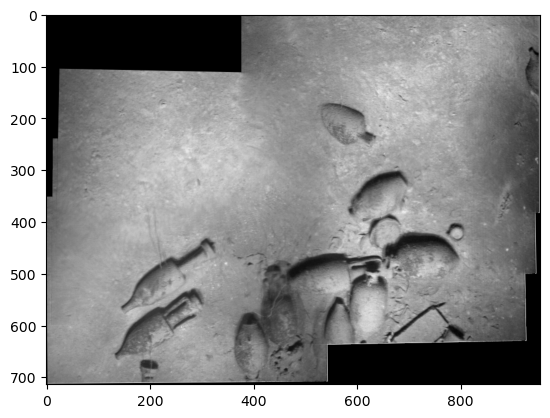

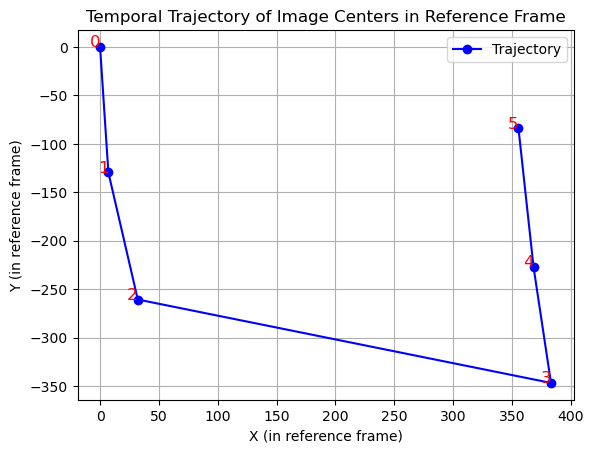

In [4]:
image_mosiacking.align_images_in_temporal_sequence()
image_mosiacking.get_temporal_trajectory()

## Propose and Validate Non Temporal Links

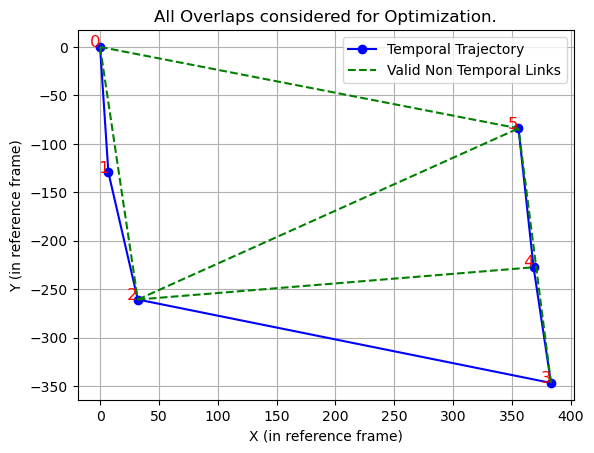

In [5]:
image_mosiacking.propose_non_temporal_links()
image_mosiacking.validate_proposed_links()

image_mosiacking.plot_all_links()

## Optimization using GTSAM

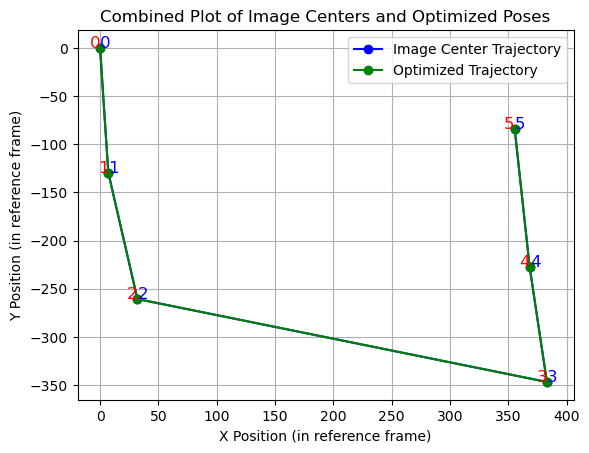

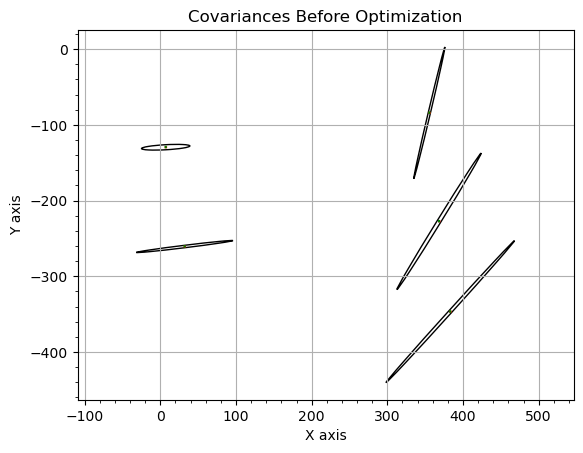

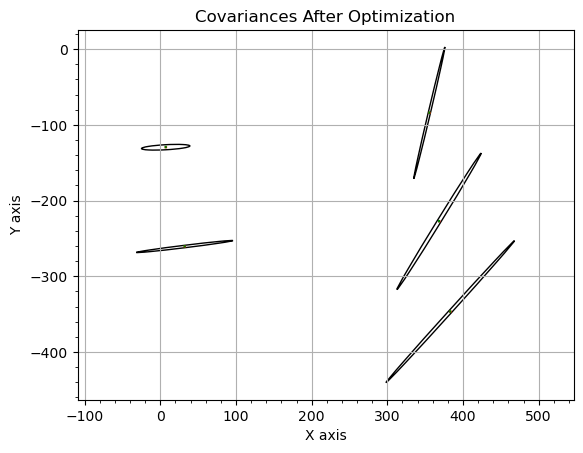

In [38]:
# Initialize optimizer object
optimizer = gt.GTSAMOptimizer(image_mosiacking_obj=image_mosiacking)

# Build and optimize graph.
optimizer.build_graph()
optimizer.optimize_graph()

optimizer.plot_combined_trajectory_and_poses()

# Plot Covariances
optimizer.plot_covariances("before")
optimizer.plot_covariances("after")

## Image Mosiacing using Optimized Trajectory

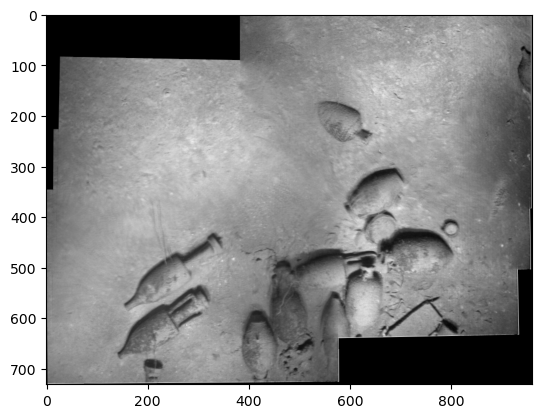

In [7]:
# Initialize optimizer object.
optimized_trajectory = optimizer.get_optimized_trajectory()

# # update the homographies in the image mosiacing graph.
image_mosiacking.update_homographies(optimized_trajectory)

# Execute image mosiacing routine.
image_mosiacking.get_panorama_canvas()
image_mosiacking.project_images_on_canvas()

## Load 29 Images

In [8]:
image_directories = ["29images/first_column", "29images/second_column", "29images/third_column", "29images/fourth_column"]
image_mosiacking_29 = im.ImageMosiacking(image_directories, False, "all_images", min_inliers=20, max_reprojection_error=2.0, link_proposal_distance_factor=2.0)

image_mosiacking_29.get_images_for_mosaicking()

## Detect & Match Features, Align Images in a temporal sequence

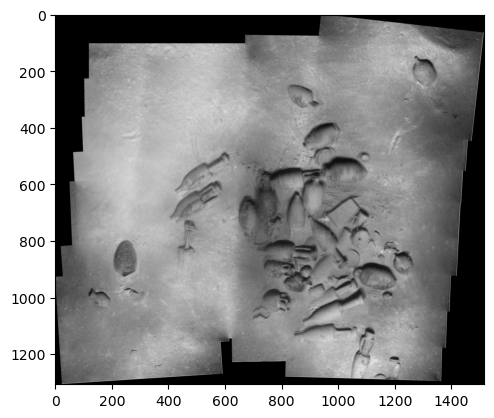

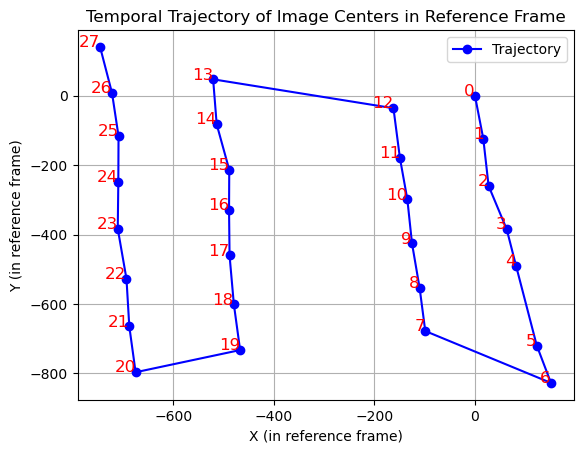

In [9]:
image_mosiacking_29.align_images_in_temporal_sequence()
image_mosiacking_29.get_temporal_trajectory()

## Propose and Validate Non Temporal Links

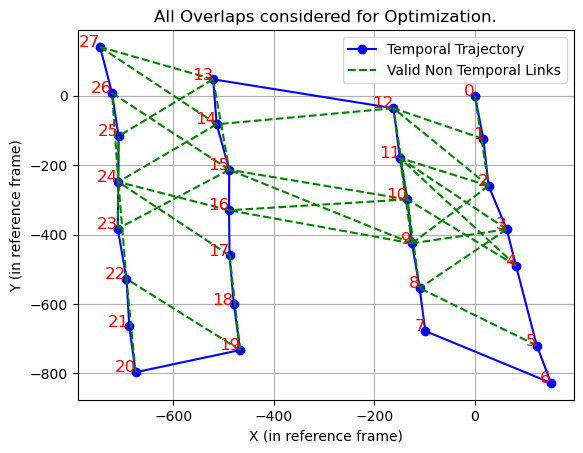

In [10]:
image_mosiacking_29.propose_non_temporal_links()
image_mosiacking_29.validate_proposed_links()
image_mosiacking_29.plot_all_links()

## Optimization using GTSAM

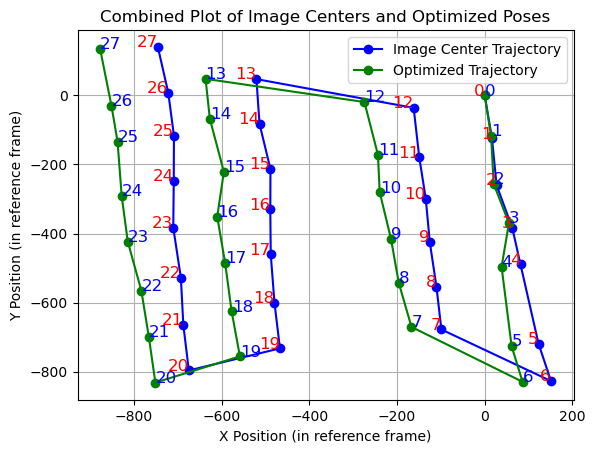

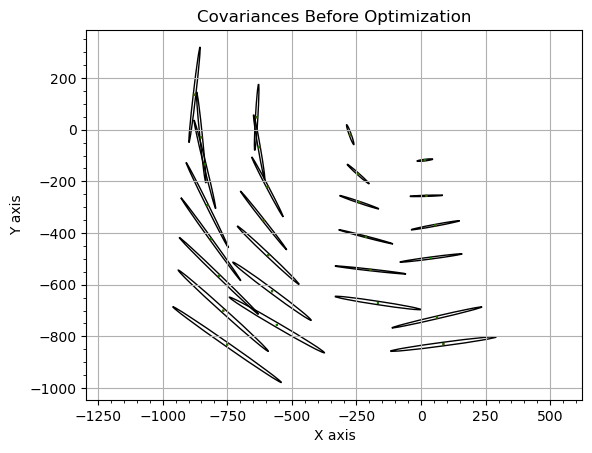

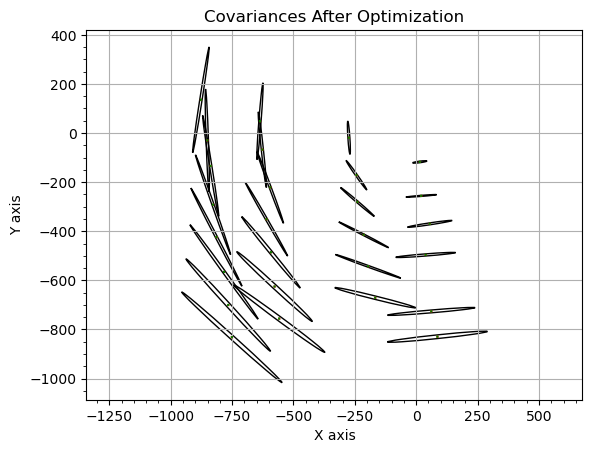

In [39]:
optimizer_2 = gt.GTSAMOptimizer(image_mosiacking_obj=image_mosiacking_29)
optimizer_2.build_graph()
optimizer_2.optimize_graph()
optimizer_2.plot_combined_trajectory_and_poses()

# Plot Covariances
optimizer_2.plot_covariances("before")
optimizer_2.plot_covariances("after")

## Image Mosiacing using Optimized Trajectory

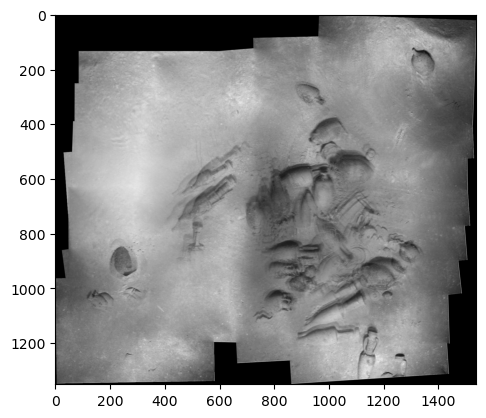

In [36]:
# Get optimized image center trajectory from the GTSAM optimizer object.
optimized_trajectory = optimizer_2.get_optimized_trajectory()

# update the homographies in the image mosiacing graph.
image_mosiacking_29.update_homographies(optimized_trajectory)

# Execute image mosiacing routine.
image_mosiacking_29.get_panorama_canvas()
image_mosiacking_29.project_images_on_canvas()